# Bayesian SN Cosmology

[Rubin et al. 2015](http://arxiv.org/abs/1507.01602) lays out a pretty complete Bayesian model for going from light curve parameters for a large, heterogeneous set of SNe to inferred cosmological parameters. However, it has a couple deficiencies: (1) There's no publicly available code, meaning that the model cannot be modified and improved. (2) The implementation runs slowly (timescale of days). In this hack, we'll start on an open-source package implementing the model and seeing if we can take advantage of aspects of the problem to make it run a whole lot faster.

## Simplistic Model

<img src="Simplified SN Cosmology PGM.jpg">

## Assigning Probability Distributions

This is mostly just following the Rubin et al. 2015 explanation, quoted below...

In [27]:
import scipy as sp
import numpy as np
import sncosmo
import matplotlib.pylab as plt
from astropy.cosmology import FlatLambdaCDM

%matplotlib nbagg

"Each simulated dataset has 250 SNe, except the highest-redshift, which has 50."

In [3]:
size_we_want = 250

"We generate the $x_{1}$ population from a unit normal distribution, centered on zero."

In [4]:
x1_true_dist = np.random.normal(loc=0, scale=1, size=size_we_want)

"We assume that the uncertainties on $m_B$, $x_{1}$, and $c$ are 0.05, 0.5, and 0.05, and are uncorrelated."

In [5]:
x1_obs_unc = 0.5*np.ones_like(x1_true_dist)

x1_obs_dist = x1_true_dist + x1_obs_unc*np.random.normal(loc=0, scale=1, size=size_we_want)

"We draw the population $c$ values from the sum of a Gaussian distribution of width 0.1 magnitudes and an exponential with rate 1/(0.1 magnitudes). We center the distribution on zero." $\beta$ is the scale parameter, which is the inverse of the rate parameter $\lambda = 1/\beta$.  The rate parameter is an alternative, widely used parameterization of the exponential distribution.

In [6]:
c_true_norm = np.random.normal(loc=0, scale=0.1, size=size_we_want)
c_true_exp = np.random.exponential(scale=0.1/1, size=size_we_want)
c_true_dist = np.add(c_true_norm, c_true_exp)

c_obs_unc = 0.5*np.ones_like(c_true_dist)

c_obs_dist = c_true_dist + c_obs_unc*np.random.normal(loc=0, scale=1, size=size_we_want)

"We generate four simulated datasets spanning the redshift ranges 0.02-0.05, 0.05-0.4, 0.2-1.0, and 0.7-1.4." We're just doing one set for now, from 0.2-1.0.

In [7]:
z_dist = np.random.uniform(0.2, 1.0, size=size_we_want)

$\alpha$ and $\beta$ are assumed to be constant, with values 0.13 and 3.0, respectively. $M_{B}$ is set to -19.1 and $\Omega_{m}$ is set to 0.3 (flat $\Lambda \text{CDM}$ model).

In [8]:
alpha = 0.13
beta = 3.0
MB = -19.1
Omega_m = 0.3
sigma_int = 0.15

We calculated the $\mu$ values using astropy.cosmology.lambdacdm().

In [9]:
cosmo = FlatLambdaCDM(H0=70, Om0=Omega_m)
mu_dist = cosmo.distmod(z_dist).value

"We assume that the intrinsic dispersion covariance matrix is correct in SALT2, and that only dispersion in $m_{B}$ (gray dispersion) remains. The statistical model does not have access to this information, and fits for the full unknown matrix, overestimating the uncertainties on $x_{1}$ and $c$, and thus slightly biasing $\alpha$ and $\beta$ away from zero (see Section 2.5). (This is not a unique problem for our framework; the old technique would have the same bias.)" We might come back to this but for now we just solved for $m_{B} = M_{B} - {\alpha}x_{1} + {\beta}{c} + \mu$ and introduced some scatter.

In [10]:
mb_true_mean = MB - alpha*x1_true_dist + beta*c_true_dist + mu_dist 
mb_true_var = sigma_int**2

mb_true = 

<IPython.core.display.Javascript object>


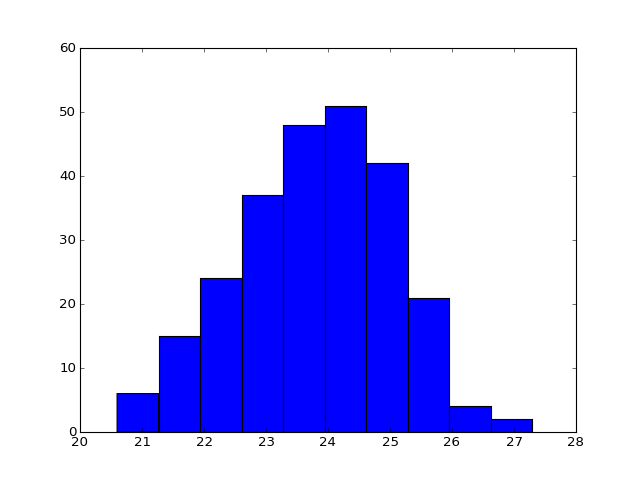

(array([  6.,  15.,  24.,  37.,  48.,  51.,  42.,  21.,   4.,   2.]),
 array([ 20.59792602,  21.26731879,  21.93671156,  22.60610433,
         23.27549709,  23.94488986,  24.61428263,  25.2836754 ,
         25.95306817,  26.62246093,  27.2918537 ]),
 <a list of 10 Patch objects>)

In [19]:
plt.figure()
plt.hist(mb_true_dist)

## Simple Monte Carlo Inference

If we were making mock data, we would do the following:

```python
    mb_obs_unc = 0.05*np.ones_like(mb_true_dist)

    mb_obs_dist = mb_true_dist + mb_obs_unc*np.random.normal(loc=0, scale=1, size=size_we_want)
```

However, right now we're going to get set up to do inference by Simple Monte Carlo: weight each sample by its parameters likelihood, and approximate posterior integrals with likelihood-weighted sums over prior samples.

In [38]:
# Let's package up the parameters, ML-style:

import pandas as pd

#par_labels = ['x1_true', 'x1_obs', 'c_true', 'c_obs', 'mb_true', 'mb_obs', 'alpha', 'beta', 'Mb', 'Omega', 'z', 'x1_dist', 'c_dist', 'sigma_int']
par_labels = ['x1_true', 'c_true', 'mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']

#pd.Series([1,3,5], index=['x1_true']) for i in nrange
#x1_obs = pd.Series([2,4,6], index=['x1_obs'])

#SN = [ pd.Series(np.ones(len(par_labels)),index=par_labels) for i in range(4)]
#print parameters

#datafr = pd.DataFrame(SN)
datafr = pd.DataFrame(np.ones((10,len(par_labels))),columns=par_labels)
datafr
#SN[0]

,x1_true,c_true,mb_true,alpha,beta,MB,Omega_m,sigma_int
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1


In [22]:
N = 2
nSN = 10
cosmo = FlatLambdaCDM(H0=70, Om0=Omega_m)
mu = cosmo.distmod(z).value

def LogGaussian(x,mu,sig):
    
    return -0.5*(x-mu)**2 /sig**2

schain = []
for i in range(N):
    datafr = pd.DataFrame(np.ones((nSN,len(par_labels))),columns=par_labels)
    datafr['alpha'] = scipy.stats.norm.rvs()
    datafr['beta'] = scipy.stats.norm.rvs()
    datafr['MB'] = scipy.stats.norm.rvs()
    datafr['sigma_int'] = scipy.stats.norm.rvs()
    datafr['Omega_m'] = scipy.stats.norm.rvs()
    datafr['x1_true'] = scipy.stats.norm.rvs(size=nSN)
    datafr['c_true'] = scipy.stats.norm.rvs(size=nSN)

    mb_true = datafr['MB'] - datafr['alpha']*datafr['x1_true'] + datafr['beta']*datafr['c_true'] + mu
    likelihood_mobs = LogGaussian(mb_obs, mb_true, datafr['sigma_int']**2)

    likelihood_x1 = LogGaussian(x1_obs, datafr['x1_true'], 0.5**2)

    likelihood_c = LogGaussian(c_obs, datafr['c_true'], 0.5**2)

    likelihood = np.sum([likelihood_mobs, likelihood_x1, likelihood_c])
    
    schain.append(datafr[['mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']])

TypeError: can only concatenate list (not "str") to list

In [41]:
schain = []
schain.append(datafr[['mb_true', 'alpha', 'beta', 'MB', 'Omega_m', 'sigma_int']])

In [39]:
params = dict(par_labels)


ValueError: dictionary update sequence element #0 has length 7; 2 is required

In [35]:
import scipy.stats
datafr['alpha'] = scipy.stats.norm.rvs()
datafr

,x1_true,c_true,mb_true,alpha,beta,Mb,Omega,x1_dist,c_dist,sigma_int
0,1,1,1,-0.803682,1,1,1,1,1,1
1,1,1,1,-0.803682,1,1,1,1,1,1
2,1,1,1,-0.803682,1,1,1,1,1,1
3,1,1,1,-0.803682,1,1,1,1,1,1
4,1,1,1,-0.803682,1,1,1,1,1,1
5,1,1,1,-0.803682,1,1,1,1,1,1
6,1,1,1,-0.803682,1,1,1,1,1,1
7,1,1,1,-0.803682,1,1,1,1,1,1
8,1,1,1,-0.803682,1,1,1,1,1,1
9,1,1,1,-0.803682,1,1,1,1,1,1


In [9]:
datafr = datafr.apply(lambda x: np.random.normal(size=x.size))

In [10]:
datafr.describe()

,x1_true,x1_obs,c_true,c_obs,mb_true,mb_obs,alpha,beta,Mb,Omega,z,x1_dist,c_dist,sigma_int
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,-0.788265,-0.237625,-0.192587,0.142651,-0.062470,-0.397101,0.289369,0.132243,0.314092,-0.039407,-0.051535,-0.074169,0.439618,-0.394322
std,1.344669,1.197922,1.265383,0.691527,0.529883,1.130651,0.938221,1.221058,0.705240,1.051746,1.118396,0.963124,1.095337,1.265405
min,-3.673799,-1.917677,-1.877887,-0.913193,-1.155533,-2.248524,-1.091744,-1.949011,-0.679502,-1.588133,-1.364033,-1.726866,-1.012572,-2.644505
25%,-1.268950,-0.850119,-0.979841,-0.428261,-0.346864,-1.304486,-0.165622,-0.515298,-0.319413,-0.657989,-0.775029,-0.694922,-0.497664,-1.224050
50%,-0.385267,-0.441106,-0.220948,0.293535,-0.077956,-0.115618,0.289306,0.201118,0.443003,-0.237594,-0.195577,0.365835,0.188582,-0.166509
75%,0.182244,0.310468,0.497273,0.687538,0.278511,0.517830,0.895714,1.052889,0.960907,0.193995,0.173680,0.558695,1.503432,0.617277
max,0.720009,2.281525,2.277365,1.048218,0.735104,0.870450,1.682525,2.027372,1.174204,1.718424,2.040970,0.908194,2.016423,1.179337


In [58]:
def likelihood(parameters):
    L = 1.0 # for now...
    return L    

In [59]:
def weight_by_likelihood(parameters):
    #  Set likelihood column of parameters:
    parameters['weight'] = likelihood(parameters)
    return parameters

In [171]:
weight_by_likelihood(datafr);

<IPython.core.display.Javascript object>


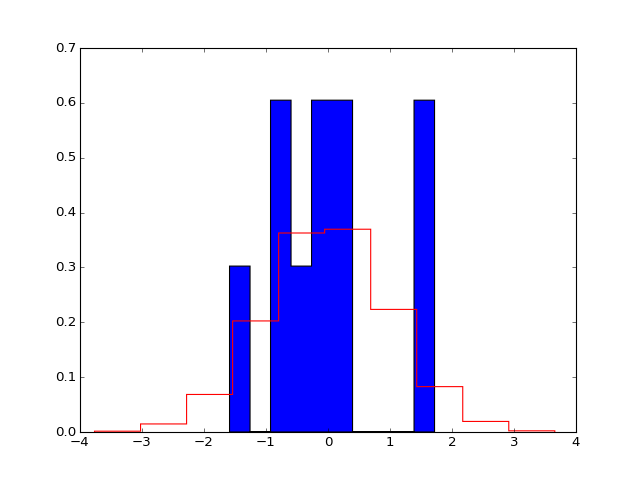

/home/marioaieie/.miniconda3/envs/astrohackweek/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(array([ 0.00148176,  0.01468294,  0.06843057,  0.20246289,  0.36276286,
         0.36963285,  0.22347701,  0.08270939,  0.01926294,  0.00215529]),
 array([-3.7655842 , -3.02322595, -2.2808677 , -1.53850944, -0.79615119,
        -0.05379294,  0.68856531,  1.43092357,  2.17328182,  2.91564007,
         3.65799832]),
 <a list of 1 Patch objects>)

In [13]:
plt.figure()
plt.hist(datafr['Omega'],histtype='stepfilled',normed=True)
plt.hist(np.random.normal(size=1e4),histtype='step',color='r',normed=True)